In [2]:
# to handle  datasets
import pandas as pd
import numpy as np
# for plotting
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split

# to display all the columns/rows in the dataframe
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
#hyperparameters
# DATASET='test'
DATASET='train'

HEATER = 'H103'
MAX_HEAD_PRESSURE = 400
MIN_HEAD_TEMPERATURE = 45
MIN_WEIGHT = 1400

In [4]:
# load the data
df = pd.read_csv('./data/' + DATASET + '/' +HEATER + '.csv', parse_dates=['utc_time'])
df.columns = ['time','batch','phase', 'heat_time', 'weight', 'head_temp', 'head_pressure', 'vac_temp']
df = df[df['phase'].str.contains('DRYING|HEATING|FEED|FEEDING') == True]

/tmp/ipykernel_20554/3490123161.py:2: DtypeWarning: Columns (1,3,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('./data/' + DATASET + '/' +HEATER + '.csv', parse_dates=['utc_time'])


In [5]:
# clean the data
df.replace({'??????': 0,'????????': 0, '???????': 0}, inplace=True)
df.dropna(inplace=True)

In [6]:
#  type conversion
df['head_temp'] = df.head_temp.astype(float)
df['weight'] = df.weight.astype(float)
df['head_pressure'] = df.head_pressure.astype(float)
df['heat_time'] = df.heat_time.astype(float).astype(int)
df['vac_temp'] = df.vac_temp.astype(float)
df['batch'] = df.batch.astype(float).astype(int)
df['phase'] = df.phase.astype('category')

In [7]:
#  label encoding
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['phase'] = le.fit_transform(df['phase'])

In [8]:
# find local maximums
from scipy.signal import argrelextrema
n = 30 # number of points to be checked before and after

df['max_temp'] = 0
df['max_temp'] = df.iloc[argrelextrema(df.head_temp.values, np.greater_equal, order=n)]['head_temp']

In [9]:
df['ready'] = 0
DELTA_TIME = 1  # time after max to be considered ready
DELTA_TEMP = 1  # temperature difference to be considered ready
df['ready'] = df.ready.astype(int)

for i in range(1, len(df) - 1):
    if df.max_temp.values[i] > 0 and df.head_temp.values[i] > MIN_HEAD_TEMPERATURE:
        # and df.weight.values[i] > MIN_WEIGHT:
        # and df.head_temp.values[i] > MIN_HEAD_TEMPERATURE \
        # and df.head_pressure.values[i] < MAX_HEAD_PRESSURE \
        local_max = df.max_temp.values[i]
        current = df.batch.values[i]
        local_max_index = i
        while df['batch'].values[i] == current and i < len(df) - 1:
            if local_max - df.head_temp.values[i] > DELTA_TEMP and i > local_max_index + DELTA_TIME:
                df.ready.values[i] = 1
            i += 1

In [10]:
df = df.drop(['max_temp'], axis=1)

In [11]:
df['head_pressure_20'] = df['head_pressure'].shift(-20)
df['head_temp_20'] = df['head_temp'].shift(-20)
df['weight_20'] = df['weight'].shift(-20)
df['heat_time_20'] = df['heat_time'].shift(-20)
df['vac_temp_20'] = df['vac_temp'].shift(-20)
df['phase_20'] = df['phase'].shift(-20)

df['head_pressure_30'] = df['head_pressure'].shift(-30)
df['head_temp_30'] = df['head_temp'].shift(-30)
df['weight_30'] = df['weight'].shift(-30)
df['heat_time_30'] = df['heat_time'].shift(-30)
df['vac_temp_30'] = df['vac_temp'].shift(-30)
df['phase_30'] = df['phase'].shift(-30)

df['head_pressure_35'] = df['head_pressure'].shift(-35)
df['head_temp_35'] = df['head_temp'].shift(-35)
df['weight_35'] = df['weight'].shift(-35)
df['heat_time_35'] = df['heat_time'].shift(-35)
df['vac_temp_35'] = df['vac_temp'].shift(-35)
df['phase_35'] = df['phase'].shift(-35)

df['head_pressure_40'] = df['head_pressure'].shift(-40)
df['head_temp_40'] = df['head_temp'].shift(-40)
df['weight_40'] = df['weight'].shift(-40)
df['heat_time_40'] = df['heat_time'].shift(-40)
df['vac_temp_40'] = df['vac_temp'].shift(-40)
df['phase_40'] = df['phase'].shift(-40)
df.dropna(inplace=True)

In [12]:

features = [
            'batch',
            'phase','heat_time','weight', 'head_temp', 'head_pressure', 'vac_temp',
            'phase_20','heat_time_20', 'weight_20', 'head_temp_20', 'head_pressure_20', 'vac_temp_20',
            'phase_30','heat_time_30', 'weight_30', 'head_temp_30', 'head_pressure_30', 'vac_temp_30',
            'phase_35','heat_time_35', 'weight_35', 'head_temp_35', 'head_pressure_35', 'vac_temp_35',
            'phase_40','heat_time_40', 'weight_40', 'head_temp_40', 'head_pressure_40', 'vac_temp_40'
            ]
label = ['ready']

X_train, X_test, y_train, y_test = train_test_split(df[features], df[label], shuffle = False)

# X_test.to_csv('./data/reference/' + HEATER + '/X_test.csv')
# y_test.to_csv('./data/reference/' + HEATER + '/y_test.csv')

In [13]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                            n_estimators=1000,
                            max_depth=5,
                            learning_rate=0.1,
                            seed=42)

In [14]:
clf_xgb.fit(X_train,
            y_train,
            verbose=True,
            early_stopping_rounds=10,
            eval_metric='auc',
            eval_set=[(X_train, y_train),(X_test, y_test)])

/home/bazdalaz/.cache/pypoetry/virtualenvs/dryers-730-aZtdCMLp-py3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/bazdalaz/.cache/pypoetry/virtualenvs/dryers-730-aZtdCMLp-py3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.97274	validation_1-auc:0.96551
[1]	validation_0-auc:0.97580	validation_1-auc:0.96674
[2]	validation_0-auc:0.97674	validation_1-auc:0.96728
[3]	validation_0-auc:0.98028	validation_1-auc:0.96791
[4]	validation_0-auc:0.98058	validation_1-auc:0.96801
[5]	validation_0-auc:0.98136	validation_1-auc:0.97006
[6]	validation_0-auc:0.98166	validation_1-auc:0.96935
[7]	validation_0-auc:0.98192	validation_1-auc:0.96993
[8]	validation_0-auc:0.98182	validation_1-auc:0.97026
[9]	validation_0-auc:0.98193	validation_1-auc:0.97089
[10]	validation_0-auc:0.98198	validation_1-auc:0.97099
[11]	validation_0-auc:0.98207	validation_1-auc:0.97100
[12]	validation_0-auc:0.98281	validation_1-auc:0.97276
[13]	validation_0-auc:0.98324	validation_1-auc:0.97131
[14]	validation_0-auc:0.98387	validation_1-auc:0.97110
[15]	validation_0-auc:0.98432	validation_1-auc:0.97151
[16]	validation_0-auc:0.98447	validation_1-auc:0.97162
[17]	validation_0-auc:0.98480	validation_1-auc:0.97142
[18]	validation_0-au

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=1000,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, ...)

In [15]:
pred = clf_xgb.predict_proba(X_test)[:,1]
thr = 0.5

<AxesSubplot:>

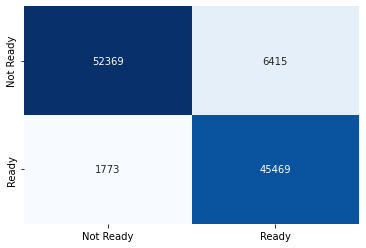

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

sns.heatmap(confusion_matrix(y_test,pred>thr),annot=True,fmt='', cmap='Blues',cbar=False, xticklabels=['Not Ready','Ready'], yticklabels=['Not Ready','Ready'])


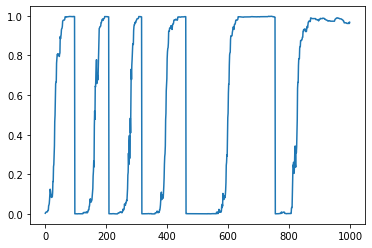

In [17]:
plt.plot(pd.Series(pred[-1000:]))

In [18]:
from sklearn.metrics import classification_report

print(HEATER,'DATASET=' + DATASET + '; MAX_HEAD_PRESSURE=' +  str(MAX_HEAD_PRESSURE) + '; MIN_HEAD_TEMPERATURE='+ str(MIN_HEAD_TEMPERATURE)+ '; MIN_WEIGHT=' + str(MIN_WEIGHT)+'; DELTA_TIME=' + str(DELTA_TIME)+'; DELTA_TEMP='+str(DELTA_TEMP),'Threshold= '+str(thr), 'features='+str(features),classification_report(y_test,pred>thr, target_names=['Not Ready','Ready']), sep='\n')
print(confusion_matrix(y_test,pred>thr),y_test.value_counts(), sep='\n')


H103
DATASET=train; MAX_HEAD_PRESSURE=400; MIN_HEAD_TEMPERATURE=45; MIN_WEIGHT=1400; DELTA_TIME=1; DELTA_TEMP=1
Threshold= 0.5
features=['batch', 'phase', 'heat_time', 'weight', 'head_temp', 'head_pressure', 'vac_temp', 'phase_20', 'heat_time_20', 'weight_20', 'head_temp_20', 'head_pressure_20', 'vac_temp_20', 'phase_30', 'heat_time_30', 'weight_30', 'head_temp_30', 'head_pressure_30', 'vac_temp_30', 'phase_35', 'heat_time_35', 'weight_35', 'head_temp_35', 'head_pressure_35', 'vac_temp_35', 'phase_40', 'heat_time_40', 'weight_40', 'head_temp_40', 'head_pressure_40', 'vac_temp_40']
              precision    recall  f1-score   support

   Not Ready       0.97      0.89      0.93     58784
       Ready       0.88      0.96      0.92     47242

    accuracy                           0.92    106026
   macro avg       0.92      0.93      0.92    106026
weighted avg       0.93      0.92      0.92    106026

[[52369  6415]
 [ 1773 45469]]
ready
0        58784
1        47242
dtype: int64


In [19]:
X_test_03 = pd.read_csv('./data/reference/H103/X_test.csv')
y_test_03 = pd.read_csv('./data/reference/H103/y_test.csv')
X_test_03.drop(['Unnamed: 0'], axis=1, inplace=True)
y_test_03.drop(['Unnamed: 0'], axis=1, inplace=True)

In [20]:
print(HEATER, 'threshold='+str(thr))
print(classification_report(y_test_03, clf_xgb.predict_proba(X_test_03)[:,1]>thr, target_names=['Not Ready','Ready']), sep='\n')
print(confusion_matrix(y_test_03, clf_xgb.predict_proba(X_test_03)[:,1]>thr),y_test_03.value_counts(), sep='\n')

H103 threshold=0.5


ValueError: Feature shape mismatch, expected: 31, got 30

In [ ]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plti

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, pred)
plti.plot(fpr, tpr)
plti.xlabel('False Positive Rate')
plti.ylabel('True Positive Rate')
plti.title('ROC Curve')
plti.show()